# Document Upload

This notebooks is for extracting, chunking and uploading to the index

All documents is in `documents` folder.

In [1]:
# Prepare environment variable
# You should check env.example file
# It's needed throughout this jupyter notebook
from dotenv import load_dotenv
load_dotenv()

True

## Extract Data
Extracting Data from `documents` path into a string data with an end result of dictionary of `{ [key: file_name] : content }`

In [2]:
# Import all needed library
import os
import fitz

In [3]:
# Import Documents Path
DOCUMENTS_PATH = os.path.abspath("documents")
DOCUMENTS_DB_PATH = os.path.join(DOCUMENTS_PATH, "data.txt")

# Get All PDF Files
documents_data = os.listdir(DOCUMENTS_PATH)
pdf_documents = []
for data in documents_data:
    data = os.path.join(DOCUMENTS_PATH, data)
    if (os.path.isfile(data) and data.endswith(".pdf")):
        pdf_documents.append(data)

In [4]:
# Extract PDF Content {[key: file_name] : content}
pdf_content = {}

def extract_pdf_content(path: str):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

for pdf_path in pdf_documents:
    file_name = os.path.basename(pdf_path)
    content = extract_pdf_content(pdf_path)
    pdf_content[file_name] = content

## Chunk Data
Process the `pdf_content` into chunks of documents.

At the end, variable of `chunk_content` will have `{ [key: file_name]: ["chunk_text1", "chunk_text2", ...] }`

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [6]:
# Initialize The "Chunker" tool

## Chunk Size
chunk_size = 4000
## Overlap Size, for good meassure, use 10-30% of the chunk size, let's use 20%
overlap_size = 4000 * 0.2
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap_size)

In [7]:
chunk_content = {}

def chunk_text(txt: str) -> list[str]:
    return text_splitter.split_text(txt)

for file_name in pdf_content:
    content = pdf_content[file_name]
    chunk_content[file_name] = chunk_text(content)

## Prepare Embedding

We will use Azure AI Foundry for the embedding
You need to prepare the `.env` file from `env.example`

For this example i'll use `text-embedding-3-small` model that has 1536 embedding size.

At the end, variable of `chunk_content` will have `{ [key: file_name]: [{content: "chunk_text_1", embeddings: [...]}, {content: "chunk_text_2", embeddings: [...]}, ...] }`

In [39]:
# Check if you already prepare the environment file
model = "text-embedding-3-small"
embedding_dimenssions = 1536
api_version = "2024-12-01-preview"

for key in ["AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [40]:
# Import the OpenAI from Azure AI Foundry
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential

In [41]:
# Prepare the embedding model
api_key = os.getenv("AZURE_OAI_KEY")
endpoint = os.getenv("AZURE_OAI_ENDPOINT")
deployment = os.getenv("AZURE_OAI_DEPLOYMENT")

client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint=endpoint,
    api_key=api_key
)

# Prepare embedding function
def embed(txt: str) -> list[float]:
    response = client.embeddings.create(
        input=[txt],
        model=deployment
    )
    embedding_data = response.data
    if len(embedding_data) != 1:
        raise "API Error"

    return embedding_data[0].embedding

In [42]:
embedded_data = {}

for file in chunk_content:
    chunks = chunk_content[file]
    file_data = []
    for chunk in chunks:
        chunk_data = {}
        chunk_data["content"] = chunk
        chunk_data["embeddings"] = embed(chunk)
        file_data.append(chunk_data)
    embedded_data[file] = file_data

## Prepare AI Search for Vector Database

We will use AI Search for vector database  
You need to prepare the `.env` file from `env.example`

In [19]:
# Check if you already prepare the environment file
index_name = "kaenova-testing-3" # You can change it, if you want to

for key in ["AZURE_AIS_ENDPOINT", "AZURE_AIS_KEY", "AZURE_OAI_ENDPOINT", "AZURE_OAI_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [20]:
# Import Azure AI Search
from azure.search.documents.indexes import SearchIndexClient

## This is for index field definition
from azure.search.documents.indexes.models import (
    SearchField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    AzureOpenAIVectorizer,
    AzureOpenAIVectorizerParameters,
    SearchIndex,
    SemanticSearch,
    SemanticConfiguration,
    SemanticPrioritizedFields,
    SemanticField
)

In [56]:
# Initiate Azure AI Search Index client
aisearch_index_client = SearchIndexClient(
    endpoint=os.getenv("AZURE_AIS_ENDPOINT"), 
    credential=AzureKeyCredential(os.getenv("AZURE_AIS_KEY")),
)

In [60]:
# 1. Configure the vector-based search  
vector_search = VectorSearch(  
     algorithms=[  
         HnswAlgorithmConfiguration(name="hnsw-algorithm"),
     ],  # Prepare the algorithm
    vectorizers=[  
        AzureOpenAIVectorizer(  
             vectorizer_name="openai-vectorizer",  
             kind="azureOpenAI",  
             parameters=AzureOpenAIVectorizerParameters(  
                 resource_url=os.getenv("AZURE_OAI_ENDPOINT"),  
                 deployment_name=os.getenv("AZURE_OAI_DEPLOYMENT"),
                 model_name=model # Use the same model name
             ),
        ),  
    ], # Prepare the vectorizer using OpenAI API. This will automatically help us to vectorize our query
    profiles=[  
         VectorSearchProfile(  
             name="hnsw-profile",  
             algorithm_configuration_name="hnsw-algorithm",  
             vectorizer_name="openai-vectorizer",  
             deployment_name=deployment
         ) # Prepare 
    ], # Create search profile that uses the algorithm and the vectorizer
)  

deployment_name is not a known attribute of class <class 'azure.search.documents.indexes._generated.models._models_py3.VectorSearchProfile'> and will be ignored


In [36]:
# 2. Prepare Index Fields
fields = [
 SearchField(
     name="id", 
     type=SearchFieldDataType.String, 
     key=True, sortable=True, filterable=True
 ), # Combination of file ID and chunk number, Primary Key (key), Can be sorted, filtered. 
 SearchField(
     name="file_name", 
     type=SearchFieldDataType.String, 
     filterable=True
 ), # A file name, can be filtered for a specific file
 SearchField(
     name="chunk", 
     type=SearchFieldDataType.String, 
     sortable=False, filterable=False, facetable=False
 ), # String that cannot be sorted, filtered, and faceted
 SearchField(
     name="chunk_vector", 
     type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
     vector_search_dimensions=embedding_dimenssions, # Based on the embeddings profile
     vector_search_profile_name="hnsw-profile" # Use the vector configuration
 ), # The vector fields, using hnsw algorithm for searching
]  

In [37]:
# 3. Configure the semantic-based search
semantic_search = SemanticSearch(
    configurations=[
        SemanticConfiguration( # Prepare only one configuration
            name="semantic-config",
            prioritized_fields=SemanticPrioritizedFields(
                title_field=SemanticField(field_name="file_name"), # Current set the 'title' from the file name
                content_fields=[SemanticField(field_name="chunk")] # Set the 'content' from the chunk
            )
        ),
    ],
    default_configuration_name="semantic-config" # Set the default configuration
)

In [38]:
# Create the search index
index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search, semantic_search=semantic_search)  
result = aisearch_client.create_or_update_index(index)  
print(f"{result.name} created")  

kaenova-testing-3 created


## Upload Embeded Data to Vector Search

In [50]:
import hashlib

# To generate id (ex. '182223cef1cf6d28cd4a8cd3f9ef385d__chunk_0001')
def generate_id(file_name: str, chunk_num: int) -> str:
    file_hash = hashlib.md5(file_name.encode()).hexdigest()
    return f"{file_hash}__chunk_{chunk_num:04d}"

In [57]:
# Get AI Search client
from azure.search.documents import SearchClient 

aisearch_client = SearchClient(
    os.getenv("AZURE_AIS_ENDPOINT"),
    index_name,
    AzureKeyCredential(os.getenv("AZURE_AIS_KEY"))
)

In [59]:
# Upload every documents
for file_name in embedded_data:
    data = embedded_data[file_name]
    for index, chunk in enumerate(data):
        chunk_id = generate_id(file_name, index+1)
        aisearch_client.upload_documents({
            "id": chunk_id,
            "file_name": file_name,
            "chunk": chunk["content"],
            "chunk_vector": chunk["embeddings"]
        })

# Closure 

After all the documents uploaded, you can check via AI Search on Azure Portal itself.  

For example we will search this
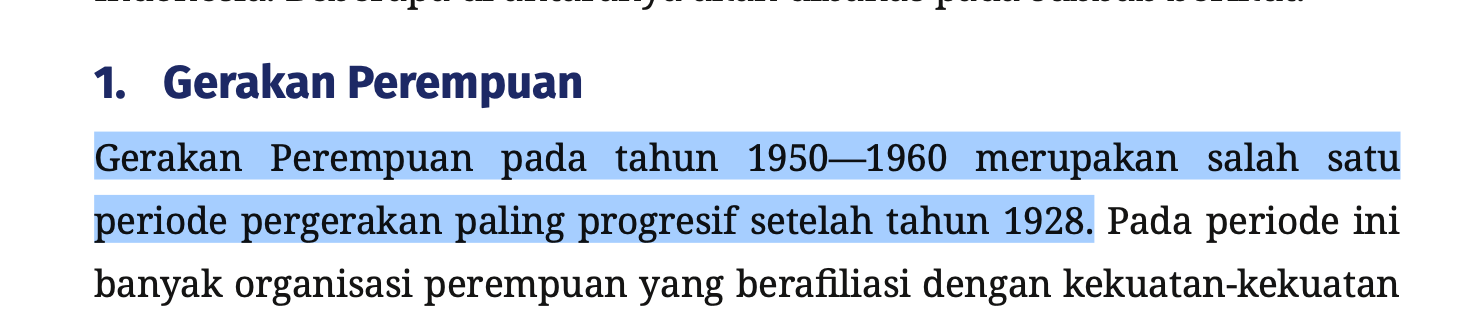

We will query "Tahun Gerakan Perempuan"

Before querying it's good to prepare the query settings to maximize the tools we have
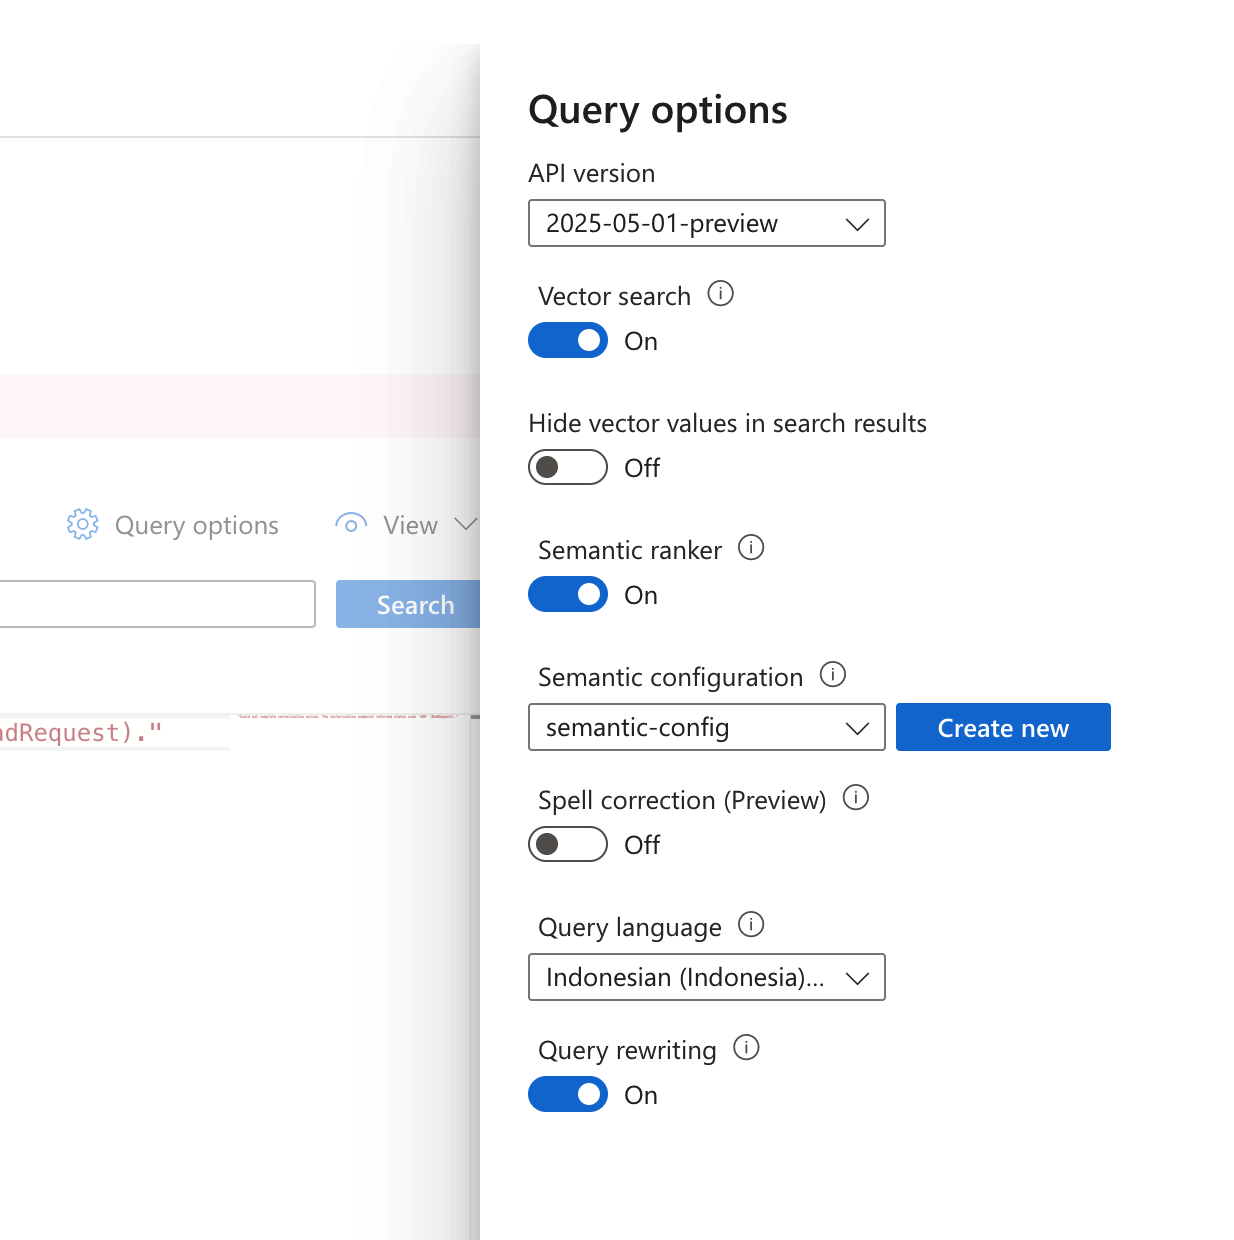

Let's see the result

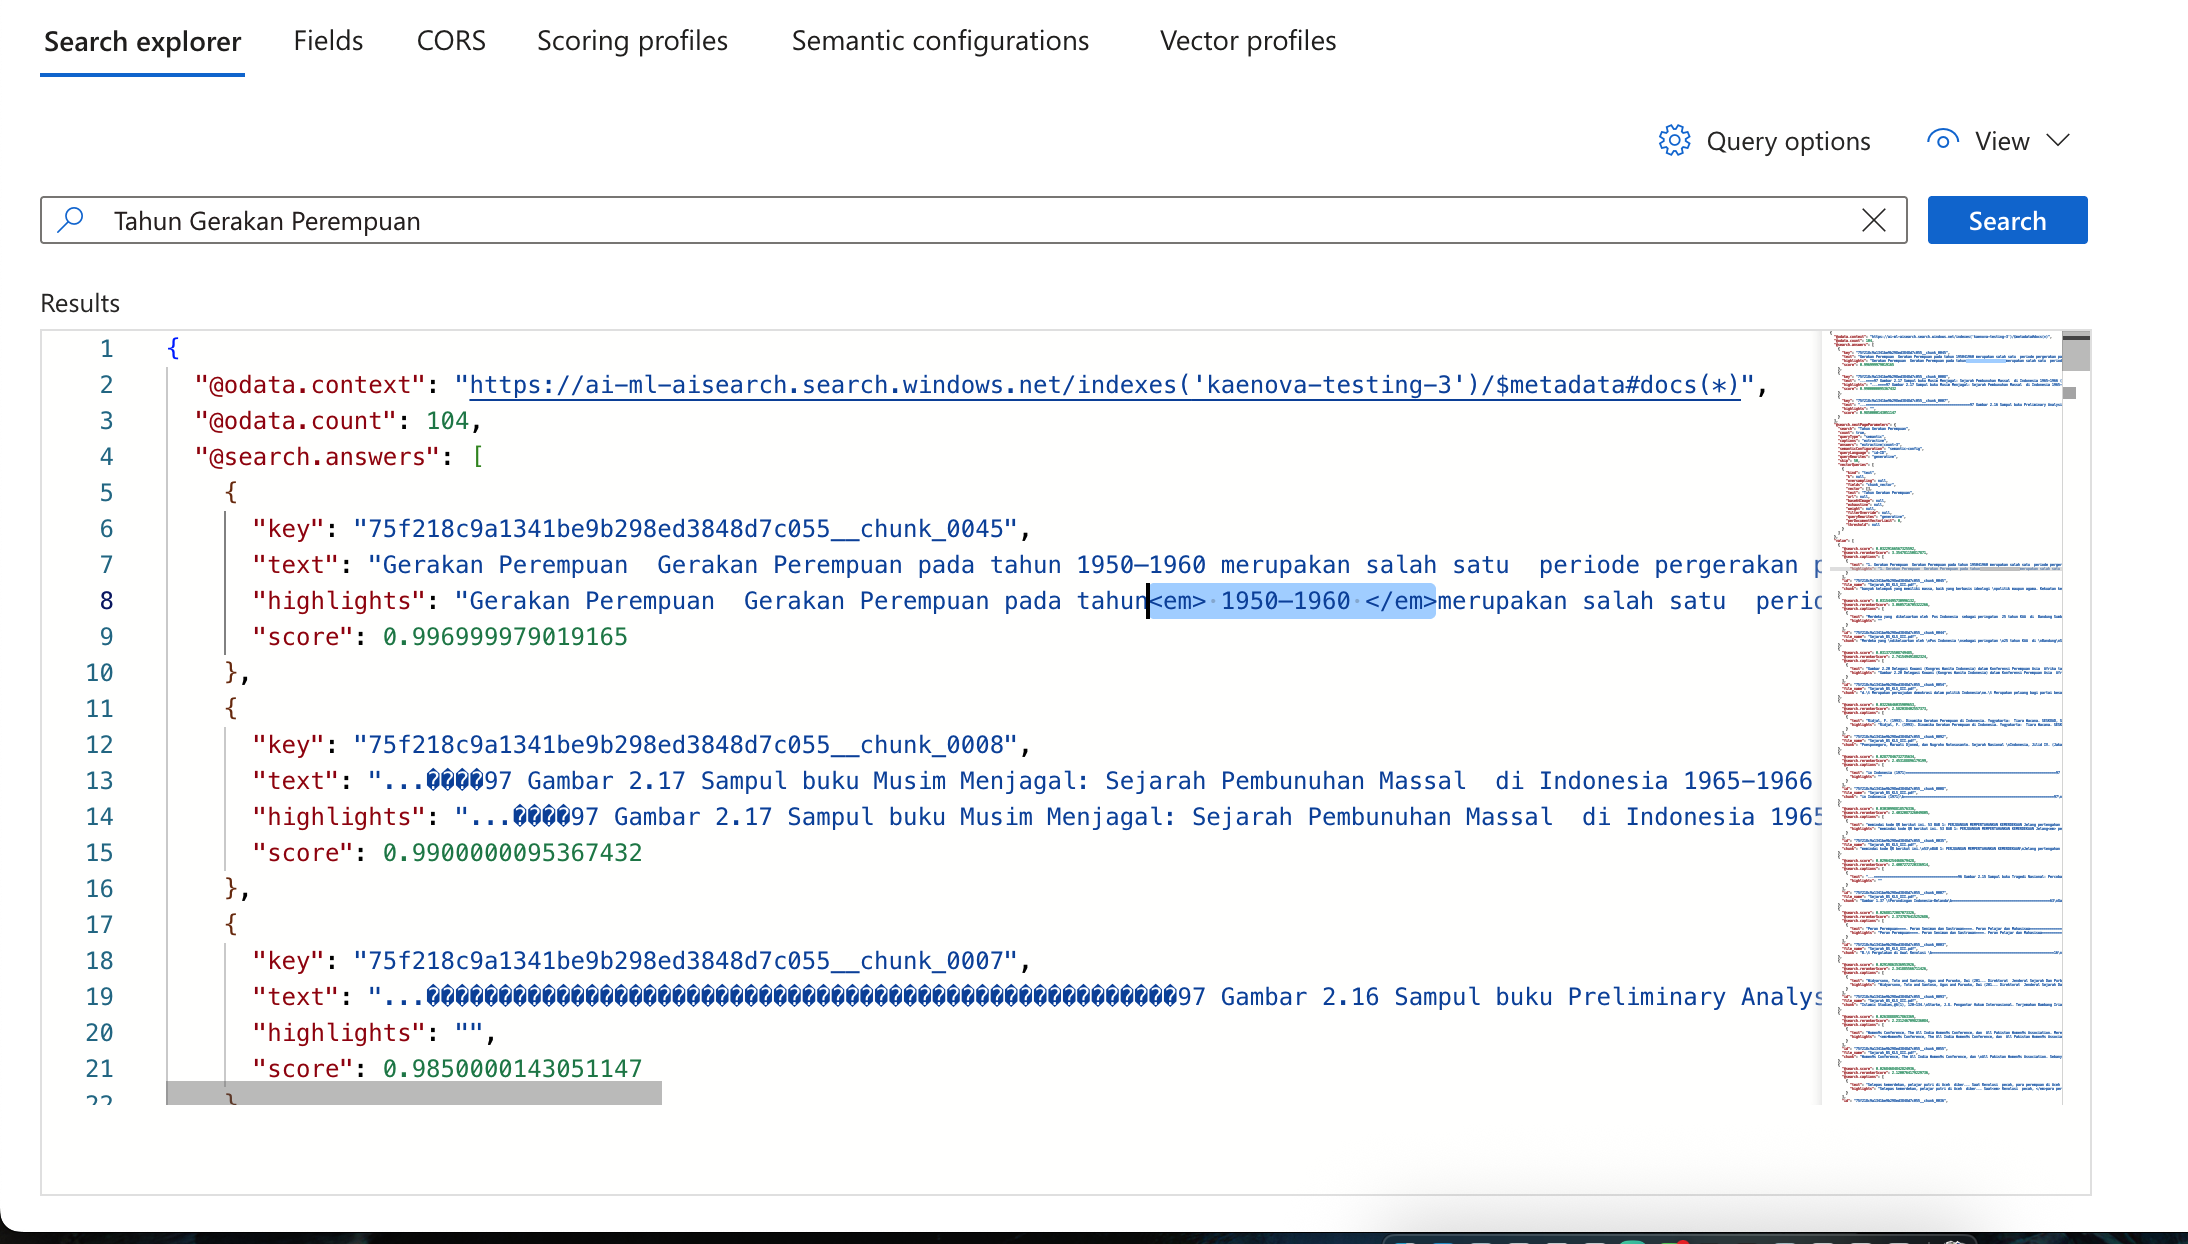

As we can see, the AI Search got the answer we want
